In [99]:
# Imports
import os
import numpy as np
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

sns.set(style='whitegrid')

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [100]:
# Load the dataset
X = np.load("dataset/X.npy")
y = np.load("dataset/Y.npy")

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

decoded_labels = np.argmax(y, axis=1)
print("Decoded label counts:", np.bincount(decoded_labels))
print("Unique labels:", np.unique(decoded_labels))

# print(f"value of y: {y[1703]}")
# print(f"value of X: {X[1703]}")

Shape of X: (2062, 64, 64)
Shape of y: (2062, 10)
Decoded label counts: [204 205 206 207 206 208 207 206 206 207]
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [101]:
# Convert labels from one-hot to class integers
y = np.argmax(y, axis=1)

# Normalize pixel values to [0, 1]
X = X / 255.0

# Reshape X for CNN (add channel dimension)
X = X.reshape(-1, 64, 64, 1)

# print(f"value of y in integer: {y[1703]}")
# print(f"value of X after normalized: {X[1703]}")

In [102]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [103]:
# Check Data Balance
(unique, counts) = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

{0: 163, 1: 164, 2: 165, 3: 166, 4: 165, 5: 166, 6: 165, 7: 165, 8: 165, 9: 165}


In [104]:
# One-hot encode labels
y_train_cat = to_categorical(y_train, num_classes=10)
y_test_cat = to_categorical(y_test, num_classes=10)

# print(f"value of y_train_cat: {y_train_cat[1]}")

In [105]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

# print("------------")

# print(f"X_train: {X_train[5]}")
# print(f"X_test: {X_test[5]}")
# print(f"y_train_cat: {y_train_cat[5]}")
# print(f"y_test_cat: {y_test_cat[5]}")

X_train shape: (1649, 64, 64, 1)
X_test shape: (413, 64, 64, 1)
y_train_cat shape: (1649, 10)
y_test_cat shape: (413, 10)


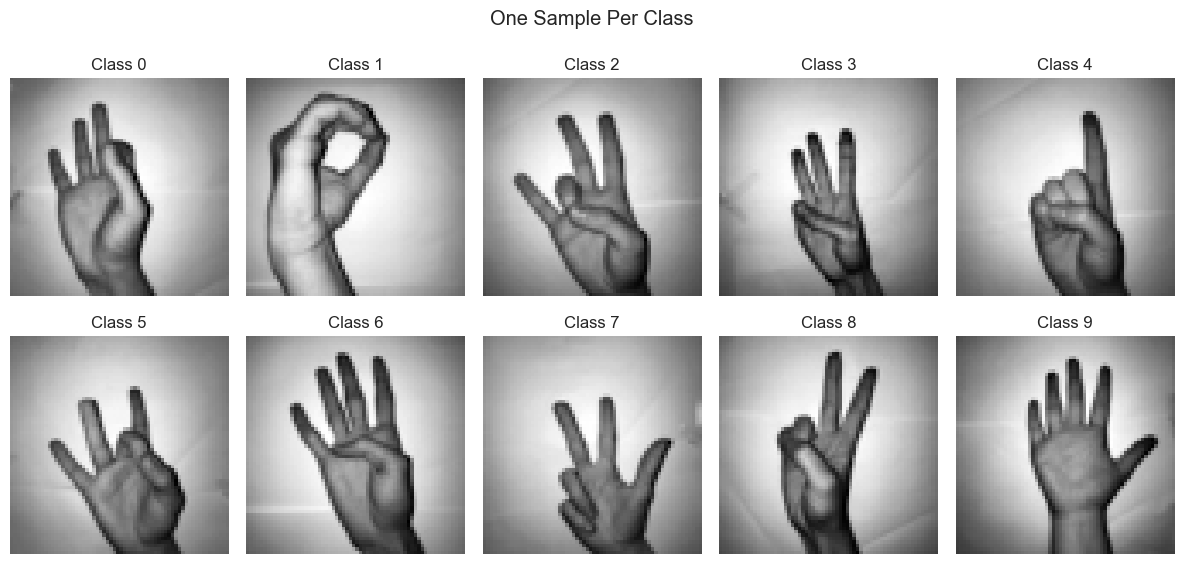

In [106]:
# Visualize sample images
plt.figure(figsize=(12, 6))
for i in range(10):
    idx = np.where(y == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[idx].reshape(64, 64), cmap='gray')
    plt.title(f"Class {i}")
    plt.axis('off')
plt.suptitle("One Sample Per Class")
plt.tight_layout()
plt.show()

In [107]:
# Define CNN model
# model = Sequential([
#     Input((64, 64, 1)),
#     Conv2D(16, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
    
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(10, activation='softmax')
# ])


model = Sequential([
    Input((64, 64, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
])


In [108]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [109]:
# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [110]:
# Checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [111]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [112]:
# Train the model
history = model.fit(X_train, y_train_cat,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[checkpoint, early_stopping, reduce_lr],
                    verbose=1)

# Overfitting a small batch for debugging
# history = model.fit(X_train[:10], y_train_cat[:10], epochs=50, verbose=2)
# history = model.fit(X_train[:128], y_train_cat[:128], epochs=50, batch_size=32)

Epoch 1/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2622 - loss: 2.1364
Epoch 1: val_accuracy improved from -inf to 0.06061, saving model to model/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.2685 - loss: 2.1273 - val_accuracy: 0.0606 - val_loss: 2.3047 - learning_rate: 1.0000e-04
Epoch 2/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6233 - loss: 1.2311
Epoch 2: val_accuracy did not improve from 0.06061
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6248 - loss: 1.2253 - val_accuracy: 0.0606 - val_loss: 2.2991 - learning_rate: 1.0000e-04
Epoch 3/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7393 - loss: 0.8254
Epoch 3: val_accuracy improved from 0.06061 to 0.14545, saving model to model/best_model.keras
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.7401 - loss: 0.8231 - val_accuracy: 0.1455 - val_loss: 2.2887 - learning_rate: 1.0000e-04
Epoch 4/50
46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7950 - los

In [113]:
# Evaluation on the train batch
# model.evaluate(X_train[:30], y_train_cat[:30])
model.evaluate(X_train[:128], y_train_cat[:128])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9948 - loss: 0.0623


[0.06812403351068497, 0.9921875]

In [114]:
# Prediction for debugging
# y_pred = model.predict(X_train[:20])

# print("Predicted class indices:", np.argmax(y_pred, axis=1))
# print("True class indices:", np.argmax(y_train_cat[:20], axis=1))

In [115]:
# Save the model
model.save("model/final_model.keras")
print("Model saved to 'model/final_model.keras'")

Model saved to 'model/final_model.keras'


In [116]:
# Load the final model
# loaded_model = load_model("model/final_model.keras")
# print("Model loaded from 'model/final_model.keras'")

# Load the best model
# best_model = load_model("model/best_model.keras")

In [117]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 85.47%
Test Loss: 0.4309


In [118]:
# Predict and analyze
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Predicted class indices:", np.argmax(y_pred_probs[:20], axis=1))
print("True class indices:", np.argmax(y_test_cat[:20], axis=1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted class indices: [6 7 9 6 4 8 9 1 5 3 4 4 0 4 9 7 0 5 7 1]
True class indices: [6 7 9 6 4 7 9 1 6 3 4 4 0 4 9 8 0 5 7 1]


In [119]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.97      0.93      0.95        41
           2       0.82      0.76      0.78        41
           3       0.78      0.78      0.78        41
           4       0.89      1.00      0.94        41
           5       0.84      0.88      0.86        42
           6       0.77      0.79      0.78        42
           7       0.88      0.85      0.86        41
           8       0.73      0.78      0.75        41
           9       0.95      0.93      0.94        42

    accuracy                           0.85       413
   macro avg       0.86      0.85      0.85       413
weighted avg       0.86      0.85      0.85       413



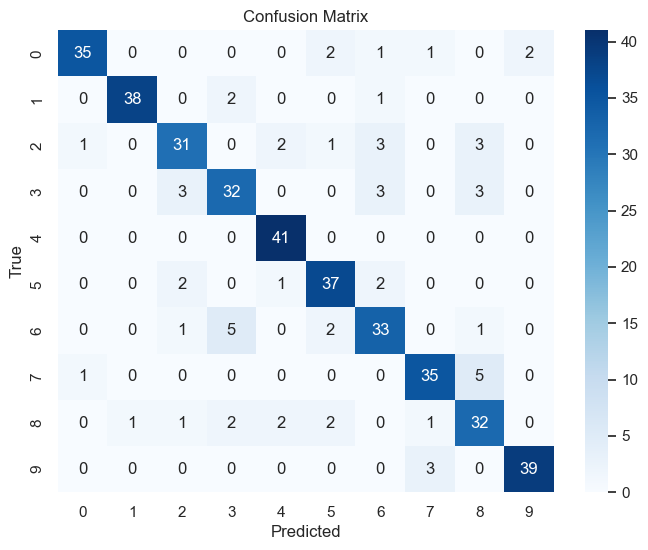

In [120]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [121]:
# Plot training history
plt.figure(figsize=(14, 5))

<Figure size 1400x500 with 0 Axes>

<Figure size 1400x500 with 0 Axes>

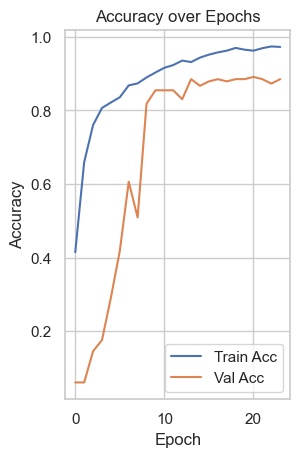

In [122]:
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

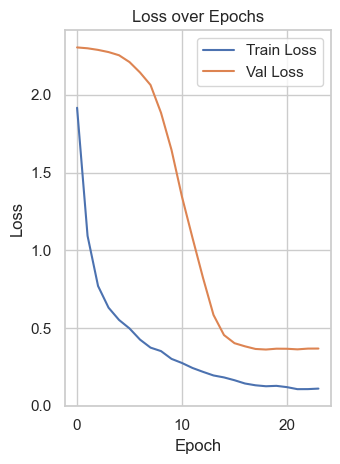

In [123]:
# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

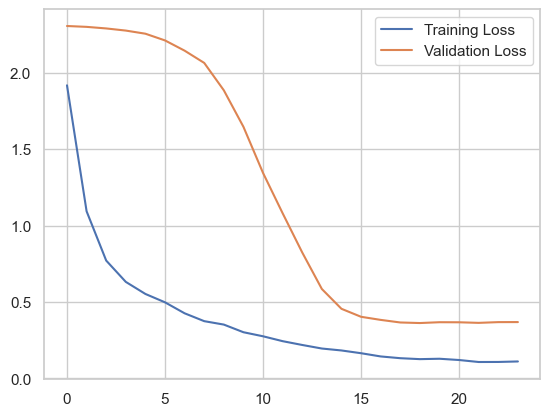

In [124]:
# Learning Rate
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()